<img width="150" alt="Logo_ER10" src="https://user-images.githubusercontent.com/3244249/151994514-b584b984-a148-4ade-80ee-0f88b0aefa45.png">

### Model interpretation using RISE for astronomical timeseries data
This notebook shows how to apply the RISE explainability method on a model trained to classify Fast Radio Burst (FRB) timeseries data. The model is a binary classifier that classifies the input as either noise or a real FRB.<br>

RISE is short for Randomized Input Sampling for Explanation of Black-box Models. It estimates the relevance empirically by probing the model with randomly masked versions of the input image to obtain the corresponding outputs.<br>

More details about this method can be found in the paper https://arxiv.org/abs/1806.07421.<br>

#### Colab Setup

In [1]:
running_in_colab = 'google.colab' in str(get_ipython())
if running_in_colab:
    # install dianna
    !python3 -m pip install dianna[notebooks]
  
    # download data used in this demo
    import os 
    base_url = 'https://raw.githubusercontent.com/dianna-ai/dianna/main/tutorials/'
    paths_to_download = ['data/arts_frb_classes.txt', 'data/FRB211024.npy']
    for path in paths_to_download:
        !wget {base_url + path} -P {os.path.dirname(path)}

In [2]:
# Download model from zenodo
import os
from urllib.request import urlretrieve

model_url = "https://zenodo.org/record/10656614/files/apertif_frb_dynamic_spectrum_model.onnx?download=1"
model_path = 'models/apertif_frb_dynamic_spectrum_model.onnx'

if not os.path.isfile(model_path):
    print("Downloading model")
    urlretrieve(model_url, model_path)

### Import libraries

In [3]:
import numpy as np
from dianna import visualization
from matplotlib import pyplot as plt
import dianna
from dianna.utils import SimpleModelRunner

np.random.seed(0)

In [4]:
classes_path = 'data/apertif_frb_classes.txt'
data_path = 'data/FRB211024.npy'

## Load and visualize the data

In [5]:
data = np.load(data_path)

Text(0.5, 1.0, 'FRB 211024')

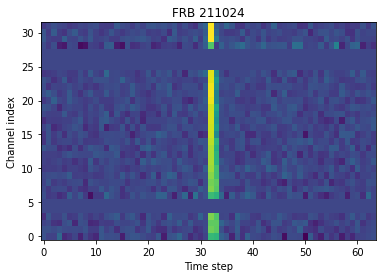

In [6]:
fig, ax = plt.subplots()
ax.imshow(data, aspect='auto', origin='lower')
ax.set_xlabel('Time step')
ax.set_ylabel('Channel index')
ax.set_title('FRB 211024')

## Select the class to run the explainer for

In [7]:
with open(classes_path) as fp:
    class_names = [line.strip() for line in fp.readlines()]
    
print(f'{class_names=}')
class_to_explain = 'FRB'
labels = [class_names.index(class_to_explain)]
print(f'Will generate explanation for class {class_to_explain}')

class_names=['Noise', 'FRB']
Will generate explanation for class FRB


## Define function to handle difference between data shape expected by DIANNA and model

Dianna expects input with shape `(time, channel)` while the model and data use `(channel, time)`
In addition, the model needs an extra emtpy axis at the end. 
(model detail: this is because the model is a CNN and the input is processed as if it is an image. The empty axis at the end is the "colour channel" axis)

To handle this, we transpose the input data before feeding it to DIANNA and we define a preprocess function that is called on the data just before it is given to the model. DIANNA creates masked data in batches, so the preprocess function receives data with shape `(batch, time, channel)` which we need to convert to `(batch, channel, time, 1)`. We also convert to `float32`, as this is the only floating point format handled by models in ONNX format.

In [8]:
def preprocess(data):
    return np.transpose(data, (0, 2, 1))[..., None].astype(np.float32)

## Run the model

In [9]:
def run_model(input_data):
    """Run the model for a single data item (no batch axis)
    """
    runner = SimpleModelRunner(model_path)
    model_output = runner(preprocess(input_data.T[None, ...]))[0]
    for idx, value in enumerate(model_output):
        print(f'{class_names[idx]}: {value:.2e}', end='    ')
    print()

run_model(data)

Noise: 2.78e-29    FRB: 1.00e+00    


## Run the explainer

In [10]:
def run_explainer(input_data):
    """Run DIANNA timeseries explainer with fixed parameters
    Returns a heatmap of the same shape as the input data
    """
    # Run the explainer with 5000 masks and a feature resolution of 8 samples, with a 50% chance of keeping a sample in each mask
    n_masks = 5000
    feature_res = input_data.shape[1] // 4  # feature size is roughly 4 timesteps
    p_keep = .5

    # Masked values are replaced by the mean of the input data
    explanation = dianna.explain_timeseries(model_path, input_data.T, method='RISE', labels=labels,
                                            n_masks=n_masks, feature_res=feature_res, p_keep=p_keep,
                                            preprocess_function=preprocess, mask_type='mean')


    # select heatmap of the first (and only) class we ran the explainer for
    heatmap = explanation[0].T
    return heatmap

heatmap = run_explainer(data)

Explaining: 100%|██████████████████████████████████████| 50/50 [00:01<00:00, 44.46it/s]


## Plot the explanation and input data next to each other

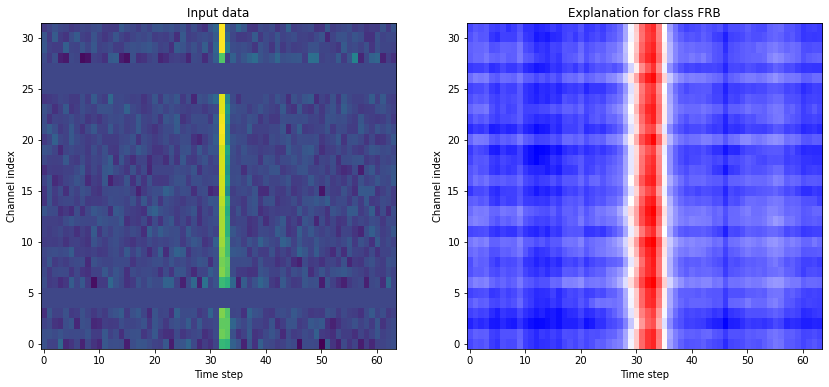

In [11]:
def plot_data_and_heatmap(input_data, output_heatmap):
    fig, axes = plt.subplots(ncols=2, figsize=(14, 6))

    ax = axes[0]
    ax.imshow(input_data, aspect='auto', origin='lower')
    ax.set_xlabel('Time step')
    ax.set_ylabel('Channel index')
    ax.set_title('Input data')

    ax = axes[1]
    ax.imshow(output_heatmap, aspect='auto', origin='lower', cmap='bwr')
    ax.set_xlabel('Time step')
    ax.set_ylabel('Channel index')
    ax.set_title(f'Explanation for class {class_to_explain}')
    
plot_data_and_heatmap(data, heatmap)

## Results

From the explainer output, we can clearly see that the model is mostly influenced by the vertical line in the center, which is exactly where the real FRB is located.

## Modify the input data
A bright FRB right in the center of the input data is perhaps the easiest for the model to classify correctly, as this is exactly what it was trained for. We now explore two ways the input data may be affected:
1. To simulate deleterious signals from other radio sources on Earth, we can add a bright signal to a few channels that is always on.
2. We can move the FRB signal away from the center of the input data.

## Move the FRB signal away from the center

In [12]:
# Shift the FRB 10 timesteps to the right
data_shifted = np.roll(data, 10)
run_model(data_shifted)

Noise: 2.81e-08    FRB: 1.00e+00    


Explaining: 100%|██████████████████████████████████████| 50/50 [00:01<00:00, 46.29it/s]


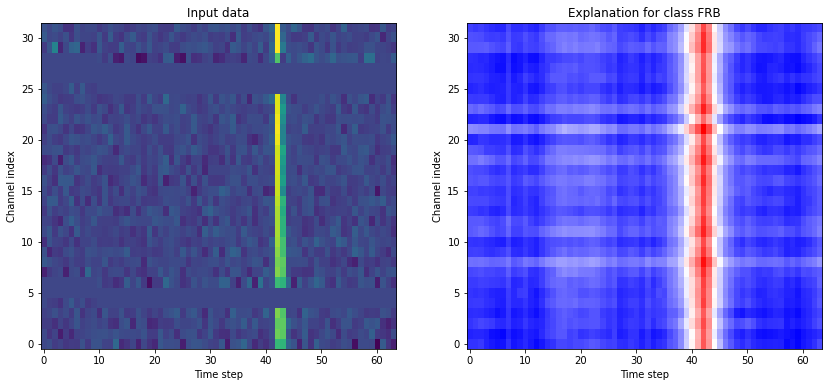

In [13]:
heatmap_shifted = run_explainer(data_shifted)
plot_data_and_heatmap(data_shifted, heatmap_shifted)

We can see that the model handles a modest shift fine, and still uses the real location of the FRB in the data in the classification. Feel free to play with the amount of shift of the FRB, and note that once it moves more than 10 timesteps, the model no longer recognizes the FRB. Instead, the FRB signal is acutally used as an argument _against_ the classification of FRB. Apparently, the model does not expect a real signal to be so far from the center.

## Add a deleterious signal

In [14]:
data_with_signal = data.copy()

# we add a deleterious signal that is slightly stronger than the real FRB
rand_mean = 1.5 * np.amax(data)
rand_std = data.std()
data_with_signal[15] = np.random.normal(rand_mean, rand_std, size=data_with_signal.shape[1])
run_model(data_with_signal)

Noise: 4.59e-13    FRB: 1.00e+00    


Explaining: 100%|██████████████████████████████████████| 50/50 [00:01<00:00, 44.58it/s]


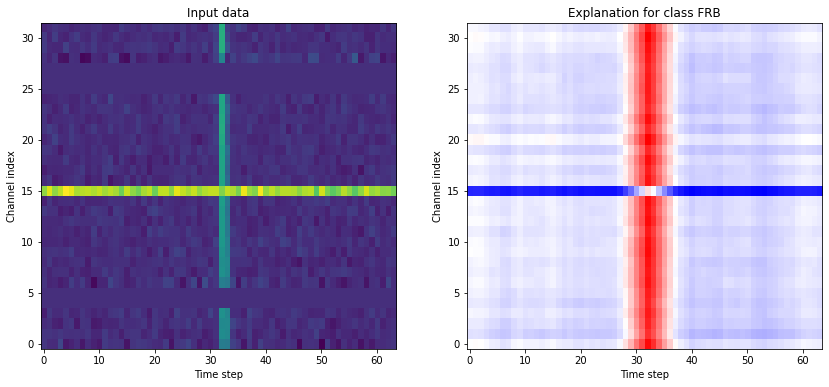

In [15]:
heatmap_with_signal = run_explainer(data_with_signal)
plot_data_and_heatmap(data_with_signal, heatmap_with_signal)

In the output we can see both the real FRB (vertical line) and deleterious signal (horizontal line). In this case, the model still recognizes the FRB. However, we can also see that the deleterious signal does push the model away from the class FRB.